In [ ]:
%pip install -r requirements.txt

In [333]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background') # Comment this line if running on light theme jupyter, for readiblity of graphs

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Importing both .csvs

In [316]:
def import_quick_data(file_in: str) -> pd.core.frame.DataFrame:
    """
    Function to quickly import and access the info in the source
    """
    
    print('###############################################')
    print(f'####### {file_in} #######')
    print('###############################################')
    
    df = pd.read_csv(file_in)
    print(f"shape is: {df.shape}")
    print(f"# of rows we missing values in some field: {sum([True for idx,row in df.iterrows() if any(row.isnull())])}")    
    print(f"# of rows we missing values per field", df.isnull().sum(), sep = '\n')
    print('Dtypes', df.dtypes, sep ='\n')
    print('Describe fields:', df.describe(), sep = '\n')
    
    numerics = ['float16', 'float32', 'float64']
    sns.boxplot(
        x="variable", 
        y="value", 
        data=pd.melt(df.select_dtypes(include=numerics))
        )
        
    df.select_dtypes(include=numerics).hist(bins=10)
    plt.show()
    
    print('###############################################')
    print(f'####### Ending call... #######')
    print('###############################################')
    print('')
    
    return df

###############################################
####### Files/hotels_information_JR.csv #######
###############################################
shape is: (282, 7)
# of rows we missing values in some field: 23
# of rows we missing values per field
our_hotel_id     0
name             0
review_score     1
stars           15
latitude         0
longitude        0
room_count      10
dtype: int64
Dtypes
our_hotel_id      int64
name             object
review_score    float64
stars           float64
latitude        float64
longitude       float64
room_count      float64
dtype: object
Describe fields:
       our_hotel_id  review_score       stars    latitude   longitude  \
count  2.820000e+02    281.000000  267.000000  282.000000  282.000000   
mean   4.409062e+06      7.977580    3.584270   51.778623    4.681475   
std    2.672583e+06      1.719415    0.762993    0.734132    0.249236   
min    3.162060e+06     -1.000000    1.000000   50.793227    4.272877   
25%    3.162863e+06      7.900000   

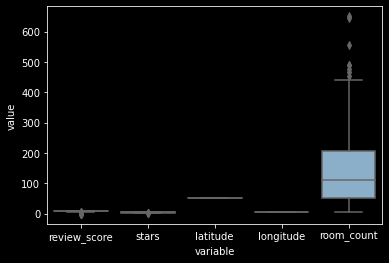

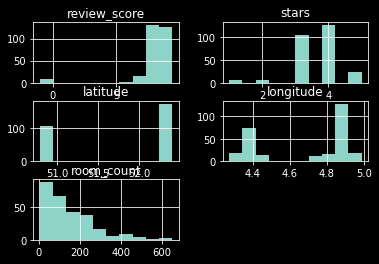

###############################################
####### Ending call... #######
###############################################

###############################################
####### Files/pricing_data_JR.csv #######
###############################################
shape is: (25380, 9)
# of rows we missing values in some field: 2783
# of rows we missing values per field
our_hotel_id              0
arrival_date              0
lead_time                 0
room_name              2624
meal_type_included     2624
max_persons            2624
price_value_ref        2783
price_value_non_ref    2624
is_sold_out               0
dtype: int64
Dtypes
our_hotel_id             int64
arrival_date            object
lead_time                int64
room_name               object
meal_type_included      object
max_persons            float64
price_value_ref        float64
price_value_non_ref    float64
is_sold_out               bool
dtype: object
Describe fields:
       our_hotel_id    lead_time   max_person

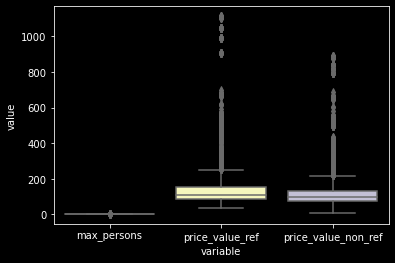

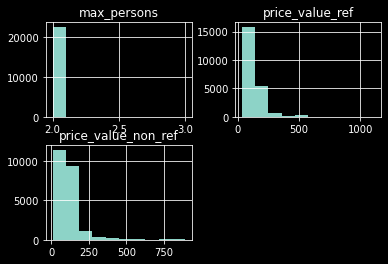

###############################################
####### Ending call... #######
###############################################



In [317]:
df_hotels = import_quick_data(file_in = 'Files/hotels_information_JR.csv')
df_pricing = import_quick_data(file_in = 'Files/pricing_data_JR.csv')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

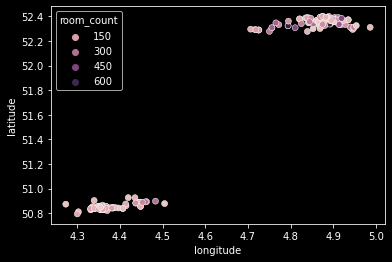

In [318]:
# Plotting geospatial data, using room_count has colour 
sns.scatterplot(data = df_hotels, x = 'longitude', y = 'latitude', hue = 'room_count')

C:\Users\josvrodrigue\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


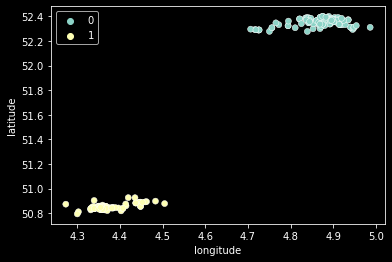

In [319]:
# Forming the 2 clusters, using KMeans with GEO data
kmeans_data = df_hotels[['longitude', 'latitude']]
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(kmeans_data)
sns.scatterplot(data = kmeans_data, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

# Create new flag for the market, and rename it using strings
df_hotels['flag_Market'] = kmeans.labels_
df_hotels.replace({"flag_Market": {0: "AME", 1: "BRU"}}, inplace = True)

In [331]:
# from scipy import stats for testing equality of variances and means in review_score, stars, and room_count
def equality_of_groups_2class(df: pd.core.frame.DataFrame, group_var: str , vars_test: list):
    
    """
    
    Function to access equality of variances and means across a 2 class group
    
    """
    
    tstats = {}
    a_filter = df[group_var] == df[group_var].unique()[0]
    group1_str = df[group_var].unique()[0]
    group2_str = df[group_var].unique()[1]
    
    for x in vars_test:

        print(x)
        print(f"Equality of variances across {group_var}, using leven test")
        t, p = levene(
            df[x][a_filter].dropna(), 
            df[x][~a_filter].dropna(),
            center='mean'
        )
        if p < 0.05:
            print(f"P-value is {round(p, 3)} -> Field {x}'s variance is statistically different between {group1_str} and {group2_str}")
        else:
            print(f"P-value is {round(p, 3)} -> Field {x}'s variance is not statistically different between {group1_str} and {group2_str}")    

        print(f"Equality of means in across groups in {group_var}, using t test")
        t, p = stats.ttest_ind(
            df[x][a_filter].dropna(), 
            df[x][~a_filter].dropna()
        )

        if p < 0.05:
            print(f"P-value is {round(p, 3)} -> Field {x}'s mean is statistically different between {group1_str} and {group2_str}")
        else:
            print(f"P-value is {round(p, 3)} -> Field {x}'s mean is not statistically different between {group1_str} and {group2_str}")

        print('')

    print(
        f"Group by {group_var}, averages",df.groupby(group_var)[test_vars].mean().reset_index(),
        f"Group by {group_var}, median",df.groupby(group_var)[test_vars].median().reset_index(),
        f"Group by {group_var}, standard deviation",df.groupby(group_var)[test_vars].agg(np.std).reset_index(),
        sep = '\n')

    return

stars
Equality of variances across flag_Market, using leven test
P-value is 0.809 -> Field stars's variance is not statistically different between BRU and AME
Equality of means in across groups in flag_Market, using t test
P-value is 0.098 -> Field stars's mean is not statistically different between BRU and AME

review_score
Equality of variances across flag_Market, using leven test
P-value is 0.015 -> Field review_score's variance is statistically different between BRU and AME
Equality of means in across groups in flag_Market, using t test
P-value is 0.036 -> Field review_score's mean is statistically different between BRU and AME

room_count
Equality of variances across flag_Market, using leven test
P-value is 0.004 -> Field room_count's variance is statistically different between BRU and AME
Equality of means in across groups in flag_Market, using t test
P-value is 0.216 -> Field room_count's mean is not statistically different between BRU and AME

Group by flag_Market, averages
  f

<AxesSubplot:xlabel='stars', ylabel='review_score'>

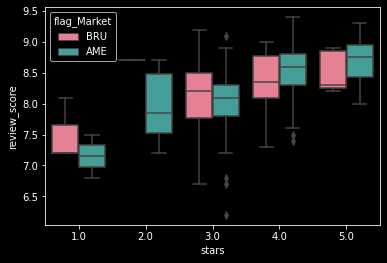

In [332]:
equality_of_groups_2class(
    df = df_hotels,
    group_var = 'flag_Market', 
    vars_test = ['stars', 'review_score', 'room_count']
    )

sns.boxplot(x = df_hotels['stars'], 
            y = df_hotels['review_score'], 
            hue = df_hotels['flag_Market'], 
            palette = 'husl')

<AxesSubplot:xlabel='flag_Market', ylabel='review_score'>

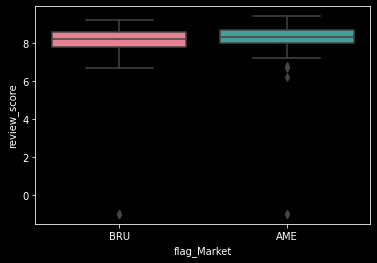

In [324]:
sns.boxplot(
    x = df_hotels['flag_Market'],
    y = df_hotels['review_score'], 
    palette = 'husl'
)

# Inner Join with df_pricing by our_hotel_id, to get more info

In [335]:
df_joined = pd.merge(df_hotels, df_pricing, on = ['our_hotel_id'], how='inner')
print(df_joined.shape)
print(df_joined.dtypes)
df_joined.head()

(25380, 16)
our_hotel_id             int64
name                    object
review_score           float64
stars                  float64
latitude               float64
longitude              float64
room_count             float64
flag_Market             object
arrival_date            object
lead_time                int64
room_name               object
meal_type_included      object
max_persons            float64
price_value_ref        float64
price_value_non_ref    float64
is_sold_out               bool
dtype: object


,our_hotel_id,name,review_score,stars,latitude,longitude,room_count,flag_Market,arrival_date,lead_time,room_name,meal_type_included,max_persons,price_value_ref,price_value_non_ref,is_sold_out
0,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,BRU,2021-01-23,1,Standard Room,NONE,2.0,NaN,87.55,False
1,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,BRU,2021-01-24,2,Standard Room,NONE,2.0,NaN,87.55,False
2,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,BRU,2021-01-25,3,Standard Room,NONE,2.0,NaN,113.05,False
3,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,BRU,2021-01-26,4,Standard Room,NONE,2.0,NaN,113.05,False
4,3169410,Hotel Indigo Brussels - City,8.4,4.0,50.855711,4.359679,283.0,BRU,2021-01-27,5,Standard Room,NONE,2.0,133.0,113.05,False


Total number of free hotels in the next 90 days in AME: 173
Total number of free hotels in the next 90 days in BRU: 105


Text(0, 0.5, '# of free hotels')

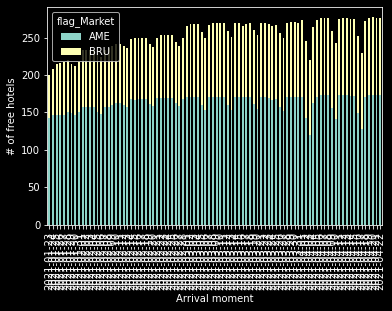

In [261]:
# How many hotels are available per arrival day in the next 90 days?
df_agg1 = df_joined.query("is_sold_out == False").groupby(
    [
        'flag_Market',
        'arrival_date'
    ]
)['our_hotel_id'].nunique().reset_index()
df_agg2 = df_agg1.pivot_table('our_hotel_id', 'arrival_date', 'flag_Market')
df_agg2
print(
    f"Total number of free hotels in the next 90 days in AME: {int(df_joined[df_joined['flag_Market'].str.contains('AME')].query('is_sold_out == False').groupby(['flag_Market'])['our_hotel_id'].nunique())}",
    f"Total number of free hotels in the next 90 days in BRU: {int(df_joined[df_joined['flag_Market'].str.contains('BRU')].query('is_sold_out == False').groupby(['flag_Market'])['our_hotel_id'].nunique())}",
    sep = '\n')

df_agg2.plot(
    kind='bar', 
    stacked=True,
#     color=['red', 'skyblue', 'green']
)
plt.xlabel('Arrival moment')
plt.ylabel('# of free hotels')

# Create month aggregations to help in EDA

Text(0, 0.5, '# of free hotels')

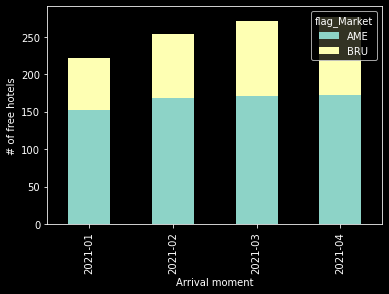

In [278]:
df_joined['month_year'] = pd.to_datetime(df_joined['arrival_date']).dt.to_period('M')
df_agg1 = df_joined.query("is_sold_out == False").groupby(
    [
        'flag_Market',
        'month_year'
    ]
)['our_hotel_id'].nunique().reset_index()
df_agg2 = df_agg1.pivot_table('our_hotel_id', 'month_year', 'flag_Market')
df_agg2.plot(
    kind='bar', 
    stacked=True
    )
plt.xlabel('Arrival moment')
plt.ylabel('# of free hotels')

<AxesSubplot:xlabel='month_year', ylabel='price_value_ref'>

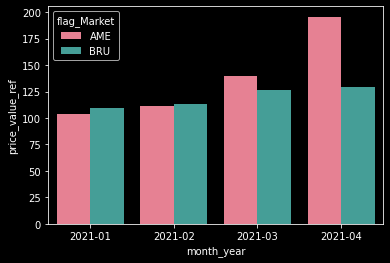

In [305]:
# What are the overall pricing patterns?
df_agg1 = df_joined[df_joined[['price_value_ref']].notnull().all(1)].groupby(
    [
        'flag_Market',
        'month_year'
    ]
)['price_value_ref'].mean().reset_index()
# df_agg2 = df_agg1.pivot_table('price_value_ref', 'month_year', 'flag_Market').reset_index()
# df_agg1
sns.barplot(data=df_agg1, x='month_year', y='price_value_ref', hue='flag_Market', palette = 'husl')

# Calculate % difference between refundable and non refundable to help in EDA

<AxesSubplot:xlabel='month_year', ylabel='pct_diff_ref_non_ref'>

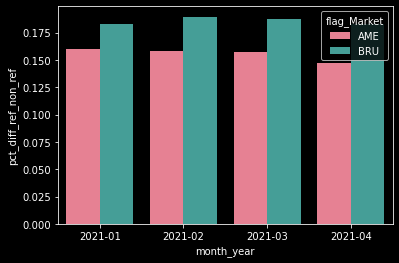

In [307]:
df_joined['pct_diff_ref_non_ref'] = (df_joined['price_value_ref'] - df_joined['price_value_non_ref']) / df_joined['price_value_non_ref']
df_agg1 = df_joined[df_joined[['pct_diff_ref_non_ref']].notnull().all(1)].groupby(
    [
        'flag_Market',
        'month_year'
    ]
)['pct_diff_ref_non_ref'].mean().reset_index()
# df_agg2 = df_agg1.pivot_table('price_value_ref', 'month_year', 'flag_Market').reset_index()
# df_agg1
sns.barplot(data=df_agg1, x='month_year', y='pct_diff_ref_non_ref', hue='flag_Market', palette = 'husl')

#### EDA Main points hotels_information_JR:
    
     - Metadata info about a total of 281 hotels
     - # of rows we missing values in some field: 23
     - review_score Coefficient of variation is around 20% indicating medium dispersion
     - stars Coefficient of variation is around 20% indicating medium dispersion
     - room_count Coefficient of variation is around 82% indicating very high dispersion in room_count which indicates. Median is 134 which indicates that 50% of the hotels have between 134 and 1113 rooms, the remaining being under 134 rooms
     - Geospatial data plotting clearly indicates 2 GEO groups (Brussels and Amsterdamm), kmeans with k=2 is formed to build the flag_Market field
     - Regarding the distributions of hotels when it comes to stars and review scores:
         - The variance and means of the hotel stars are not statistically different between Brussels and Amsterdamm
         - The variance and means of the hotel review scores are statistically different between Brussels and Amsterdamm:
             - Amsterdam has higher average score than Brussels (8,1 vs 7,7)
             - Difference in median is lower (8,3 vs 8,2), indicating strong presence of outliers (more in Brussels than Amsterdam)
     
#### EDA Main points pricing_data_JR, answering the questions:
    
     - # of rows we missing values in some field: 2783
     - Total number of free hotels in the next 90 days in Amsterdamm: 173
     - Total number of free hotels in the next 90 days in Brussels: 105
     - Logically Quantity of available hotels are less in months closer to 2021-01-22
     - Regarding pricing patterns:
         - price_value_ref are similar between the groups in JAN, FEV but tend to be higher Amsterdamm during MAR and APR
         - difference between refundable and non refundable is higher in Brussels, meaning that the cost of having a refundable offer is higher in Brussels than Amesterdamm